In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os
import nrrd
from matplotlib.backends.backend_pdf import PdfPages

In [58]:
# corta imagem 2d, de modo a eliminar pixels pretos, deixando só um retângulo ajustado ao cérebro
def crop_black_slices_2d(data):
        if np.count_nonzero(data) == 0:
                return [], []
        
        right, left, top, down = data.shape[1]-1, 0, 0, data.shape[0]-1

        while np.count_nonzero(data[:, left]) == 0: # anda com limite esquerdo pra direita até achar um pixel não preto
                left += 1

        while np.count_nonzero(data[:, right]) == 0: # anda com limite direito pra esquerda até achar um pixel não preto
                right -= 1

        while np.count_nonzero(data[top, :]) == 0: # anda com limite inferior pra cima até achar um pixel não preto
                down += 1

        while np.count_nonzero(data[down, :]) == 0: # anda com limite superior pra baixo até achar um pixel não preto
                top -= 1

        data_2d = data[down:top, left:right]

        return data_2d, [left, right, top, down]

# cria o grid, encaixando os quadrados até o eixo central
def create_grid_half_vertical(data, size):
    grid = []
    width = data.shape[1]
    
    for i in range(0, (data.shape[0] - size + 1), size):
        for j in range(0, width, size):
            if j + size > width:  # Garante que o quadrado não atravesse o centro
                break
            grid.append([i, i + size - 1, j, j + size - 1])  # [y1, y2, x1, x2]
    
    return grid

# alinha o grid das pontas até encontrar o cérebro, evitando recortes puramente pretos
# implementar: descarte de fatias com poucos pixels, tratamento de casos onde um quadradinho nunca acha cérebro, então anda até passar do limite do vetor e achar erro
def move_grid(data, grid):
    new_grid = []
    width = data.shape[1]

    for rect in grid:
        y1, y2, x1, x2 = rect[0], rect[1], rect[2], rect[3]
        
        # Verifica se o quadrado contém apenas pixels pretos
        if np.count_nonzero(data[y1:y2+1, x1:x2+1]) == 0:
            continue
        
        # Movimenta o grid para evitar regiões completamente pretas
        while y2 < data.shape[0] - 1:
            if np.count_nonzero(data[y1, x1:x2+1]) > 0:  # Se há conteúdo, sai do loop
                break
            y1 += 1
            y2 += 1

        while y1 > 0:
            if np.count_nonzero(data[y2, x1:x2+1]) > 0:  # Se há conteúdo, sai do loop
                break
            y1 -= 1
            y2 -= 1

        while x2 < data.shape[1] - 1:
            if np.count_nonzero(data[y1:y2+1, x1]) > 0:  # Se há conteúdo, sai do loop
                break
            x1 += 1
            x2 += 1

        while x1 > 0:
            if np.count_nonzero(data[y1:y2+1, x2]) > 0:  # Se há conteúdo, sai do loop
                break
            x1 -= 1
            x2 -= 1

        # Garante que o quadrado não atravesse o meio da imagem
        if x1 < width and x2 >= width:
            continue

        # Após movimentar, verifica se o quadrado contém pixels diferentes de preto
        if (
            0 <= y1 < data.shape[0]
            and 0 <= y2 < data.shape[0]
            and 0 <= x1 < data.shape[1]
            and 0 <= x2 < data.shape[1]
            and np.count_nonzero(data[y1:y2+1, x1:x2+1]) > 0
        ):
            new_grid.append([y1, y2, x1, x2])

    return new_grid


# espeçha o grid
# a ideia é a funcao create_grid_half criar metade do grid, e a outra metade ser espelhada com essa função
def mirror_grid_vertical(grid, data):
    shape = data.shape
    mirror = []
    new_grid = []

    for rect in grid:
        y1, y2, x1, x2 = rect[0], rect[1], rect[2], rect[3]  # Pega grid existente
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='red', facecolor='none'))

        # Calcula o espelhamento em relação ao eixo vertical (colunas)
        x3, x4 = shape[1] - x2 - 1, shape[1] - x1 - 1  # Inverte as colunas
        y3, y4 = y1, y2  # Linhas permanecem iguais
        plt.gca().add_patch(plt.Rectangle((x3, y3), x4-x3, y4-y3, linewidth=1, edgecolor='blue', facecolor='none'))

        mirror.append([y3, y4, x3, x4])  # Adiciona o retângulo espelhado

    new_grid = grid + mirror  # Concatena o grid original com o espelhado

    return new_grid

(197, 189)
(197, 189)
Paciente sub-00H10 recortado com sucesso!
(197, 189)
(197, 189)
Paciente sub-02A13 recortado com sucesso!
(197, 189)
(197, 189)
Paciente sub-03C08 recortado com sucesso!
(197, 189)
(197, 189)
Paciente sub-06C09 recortado com sucesso!
(197, 189)
(197, 189)
Paciente sub-14F04 recortado com sucesso!
(197, 189)
(197, 189)
Paciente sub-16E03 recortado com sucesso!
(197, 189)
(197, 189)
Paciente sub-16G09 recortado com sucesso!
(197, 189)
(197, 189)
Paciente sub-16I12 recortado com sucesso!
(197, 189)
(197, 189)
Paciente sub-19F09 recortado com sucesso!
(197, 189)
(197, 189)
Paciente sub-19G04 recortado com sucesso!
(197, 189)
(197, 189)
Paciente sub-22F14 recortado com sucesso!
(197, 189)
(197, 189)
Paciente sub-25B08 recortado com sucesso!
(197, 189)
(197, 189)
Paciente sub-26B09 recortado com sucesso!
(197, 189)
(197, 189)
Paciente sub-29D03 recortado com sucesso!
(197, 189)
(197, 189)
Paciente sub-31F07 recortado com sucesso!
(197, 189)
(197, 189)
Paciente sub-34J06

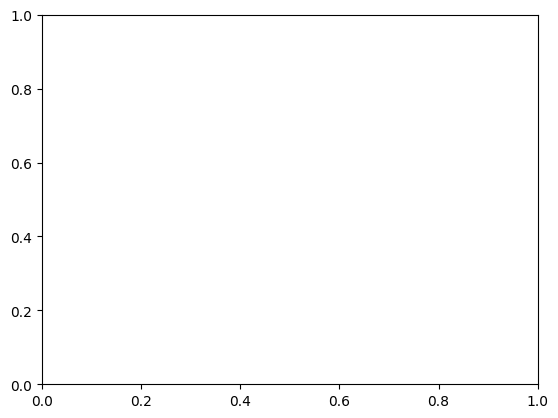

In [ ]:
# informações pra analisar dados

imagens = "Patients_Displasya"
mascara = "Mascaras"
coordinates_path = f"Coordenadas_grid"

total_label1 = []
excluded_patients = ["sub-54K08", "sub-87G01", "sub-89A03", "sub-90K10"]

for img, mask in zip([f for f in os.listdir(imagens) if f.endswith(('.nii', '.nii.gz'))], [f for f in os.listdir(mascara) if f.endswith(('.nrrd', '.nii', '.nii.gz'))]):    
    if img.split('_')[0] in excluded_patients:
        continue
    data = nib.load(os.path.join(imagens, img)).get_fdata()
    lesion_data, _ = nrrd.read(os.path.join(mascara, mask))
    
    # Rotacionar as imagens e as máscaras 180 graus
    data = np.rot90(data, k=3)  # Rotaciona a imagem 90 graus
    lesion_data = np.rot90(lesion_data, k=3)  # Rotaciona a máscara 90 graus
    
    # Verifica o formato das imagens
    print(data[2].shape)
    print(lesion_data[2].shape)

    # Contador para acompanhar quantas fatias foram processadas
    processed_slices = 0

    # Diretório de saída para salvar as fatias
    output_dir_left = os.path.join(f"Novo_Contralateral/{img.split('_')[0]}", "left")
    output_dir_right = os.path.join(f"Novo_Contralateral/{img.split('_')[0]}", "right")
    output_dir_lesion_left = os.path.join(f"Novo_Contralateral/{mask.split(' ')[0]}", "lesion_left")
    output_dir_lesion_right = os.path.join(f"Novo_Contralateral/{mask.split(' ')[0]}", "lesion_right")
    os.makedirs(output_dir_left, exist_ok=True)
    os.makedirs(output_dir_right, exist_ok=True)
    os.makedirs(output_dir_lesion_left, exist_ok=True)
    os.makedirs(output_dir_lesion_right, exist_ok=True)

    coordinates_path = f"Coordenadas_grid/{img.split('_')[0]}"
    os.makedirs(coordinates_path, exist_ok=True)
    
    # Loop para cada fatia axial
    for slice_idx in range(lesion_data.shape[2]):
        # Pega a lesão da fatia axial atual
        lesion_slice_data = lesion_data[16:233-17, 18:197-19, slice_idx]
        lesion_slice_data = np.where(lesion_slice_data>0.9, 1, 0)
        
        # Pega a fatia axial atual
        slice_data = data[16:233-17, 18:197-19, slice_idx]
        
        # Total de pixels na subimagem
        total_pixels = slice_data.size
        # Número de pixels não-preto
        non_zero_pixels = np.count_nonzero(slice_data)
        # Proporção de pixels não-preto
        non_black_ratio = non_zero_pixels / total_pixels if total_pixels > 0 else 0
        
        if np.any(slice_data == 1) and non_black_ratio >= 0.04:
            grid_img = create_grid_half_vertical(slice_data, 40) # cria grid da imagem

            adjusted_grid_img = move_grid(slice_data, grid_img) # move cada quadradinho para encaixar no cérebro, minimizando espaços pretos

            mirrored_grid  = mirror_grid_vertical(adjusted_grid_img, slice_data) # espalha o novo grid ajustado
            
            # Separar subimagens em lados esquerdo/direito
            subimages = []
            for idx, rect in enumerate(mirrored_grid):
                y1, y2, x1, x2 = rect
                subimage = slice_data[y1:y2+1, x1:x2+1]
                # Garantir correspondência de índice entre esquerdo e direito
                position = f"left_{(idx // 2) + 1}" if idx % 2 == 0 else f"right_{(idx // 2) + 1}"
                subimages.append((subimage, position))
            
            if len(subimages) == 0:
                continue
            
            processed_slices += 1
            
            output_dir_left_slice = os.path.join(output_dir_left, f"Slice{slice_idx}/")
            output_dir_right_slice = os.path.join(output_dir_right, f"Slice{slice_idx}/")

            os.makedirs(output_dir_left_slice, exist_ok=True)
            os.makedirs(output_dir_right_slice, exist_ok=True)
            
            # Salvar subimagens para slice_data
            for subimage, position in subimages:            
                if position.startswith("left"):
                    output_path = os.path.join(output_dir_left, f"Slice{slice_idx}/{position}.nii.gz")
                else:
                    output_path = os.path.join(output_dir_right, f"Slice{slice_idx}/{position}.nii.gz")

                subimage_nii = nib.Nifti1Image(subimage, affine=np.eye(4))
                nib.save(subimage_nii, output_path)

            # Aplicar o mesmo grid em lesion_slice_data
            subimages_lesion = []
            for idx, rect in enumerate(mirrored_grid):
                y1, y2, x1, x2 = rect
                subimage_lesion = lesion_slice_data[y1:y2+1, x1:x2+1]
                # Garantir correspondência de índice entre esquerdo e direito
                position = f"left_{(idx // 2) + 1}" if idx % 2 == 0 else f"right_{(idx // 2) + 1}"
                subimages_lesion.append((subimage_lesion, position))

            output_dir_lesion_left_slice = os.path.join(output_dir_lesion_left, f"Slice{slice_idx}")
            output_dir_lesion_right_slice = os.path.join(output_dir_lesion_right, f"Slice{slice_idx}")
            
            os.makedirs(output_dir_lesion_left_slice, exist_ok=True)
            os.makedirs(output_dir_lesion_right_slice, exist_ok=True)
            
            # Salvar subimagens para lesion_slice_data
            for subimage, position in subimages_lesion:            
                if position.startswith("left"):
                    output_path = os.path.join(output_dir_lesion_left, f"Slice{slice_idx}/{position}.nii.gz")
                else:
                    output_path = os.path.join(output_dir_lesion_right, f"Slice{slice_idx}/{position}.nii.gz")

                subimage_nii = nib.Nifti1Image(subimage, affine=np.eye(4))
                nib.save(subimage_nii, output_path)
            
            coordinates_path = f"Coordenadas_grid/{img.split('_')[0]}/Slice_{slice_idx}.txt"
            # Escreve as coordenadas no arquivo TXT
            with open(coordinates_path, 'w') as f:
                for rect in mirrored_grid:
                    y1, y2, x1, x2 = rect
                    f.write(f"{y1},{y2},{x1},{x2}\n")
    print(f"Paciente {img.split('_')[0]} recortado com sucesso!")

(233, 197, 189)
233
197
189


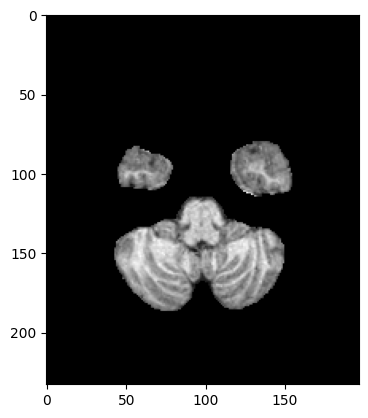

In [82]:
# informações pra analisar dados

img_path = 'Patients_Displasya/sub-35E12_ses-01_acq-256_desc-reg_desc-biascorr_desc-brainext_T1w.nii.gz'
z_idx = 25
img = nib.load(img_path)
data_3d = img.get_fdata()
data_3d = np.rot90(data_3d, k=1)  # Rotaciona a imagem 90 graus


print(data_3d.shape)
print(data_3d.shape[0])
print(data_3d.shape[1])
print(data_3d.shape[2])

plt.imshow(data_3d[:, :, z_idx], cmap='gray')
plt.show()

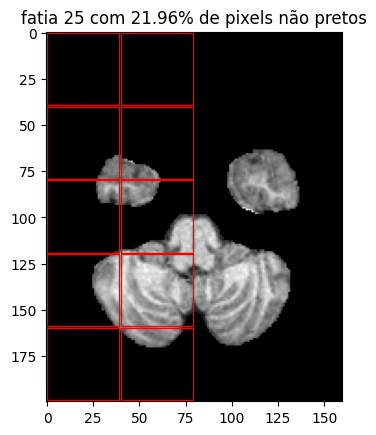

In [ ]:
img_test = data_3d[16:233-17, 18:197-19, z_idx]  # Para deixar com dimensões (160, 200)

if np.count_nonzero(img_test) != 0:  # Só executa se a fatia tiver pixels não pretos

    # Divida a imagem em duas metades verticais
    half_width = data_3d.shape[1] // 2
    left_half = data_3d[:, :half_width]
    right_half = data_3d[:, half_width:]

    # Conte os pixels não pretos em cada metade
    left_nonzero = np.count_nonzero(left_half)
    right_nonzero = np.count_nonzero(right_half)

    # Determine a metade com mais cérebro
    if left_nonzero > right_nonzero:
        chosen_half = left_half
        mirror_side = "left"
    else:
        chosen_half = right_half
        mirror_side = "right"
        
    grid = create_grid_half_vertical(chosen_half, 40)  # Substituir pela função para grid vertical

    plt.imshow(img_test, cmap='gray')
    plt.title(f"fatia {z_idx} com {np.count_nonzero(img_test)/img_test.size*100:.2f}% de pixels não pretos")  # Exibe porcentagem de pixels não pretos

    for rect in grid:
        y1, y2, x1, x2 = rect[0], rect[1], rect[2], rect[3]
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='red', facecolor='none'))

    plt.show()

In [54]:
for item in grid:
    print(item)

[0, 39, 0, 39]
[40, 79, 0, 39]
[80, 119, 0, 39]
[120, 159, 0, 39]
[160, 199, 0, 39]


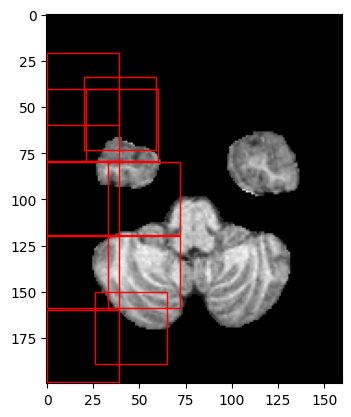

In [89]:
plt.imshow(img_test, cmap='gray')

adjusted_grid = move_grid(img_test, grid) # move cada quadradinho para encaixar no cérebro, minimizando espaços pretos

for rect in adjusted_grid:
    
    y1, y2, x1, x2 = rect[0], rect[1], rect[2], rect[3]

    plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='red', facecolor='none'))

plt.show()

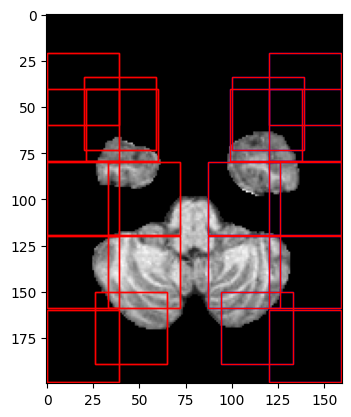

In [90]:
plt.imshow(img_test, cmap='gray')

adjusted_grid = move_grid(img_test, grid) # move cada quadradinho para encaixar no cérebro, minimizando espaços pretos

mirror_adjusted_grid = mirror_grid_vertical(adjusted_grid, img_test) # espalha o novo grid ajustado

for rect in mirror_adjusted_grid:
    
    y1, y2, x1, x2 = rect[0], rect[1], rect[2], rect[3]

    plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='red', facecolor='none'))

plt.show()

In [57]:
for item in mirror_adjusted_grid:
    print(item)

[35, 74, 19, 58]
[40, 79, 19, 58]
[80, 119, 11, 50]
[120, 159, 11, 50]
[132, 171, 12, 51]
[35, 74, 101, 140]
[40, 79, 101, 140]
[80, 119, 109, 148]
[120, 159, 109, 148]
[132, 171, 108, 147]
